In [67]:
import os
import sys
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

import sklearn
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_curve, auc, plot_roc_curve
from category_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder as ohe


import warnings 
warnings.filterwarnings("ignore")


In [6]:
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"joblib Version: {joblib.__version__}")
print(f"lightgbm Version: {lgb.__version__}")


Pandas Version: 1.4.3
Numpy Version: 1.23.1
scikit-learn Version: 1.1.2
joblib Version: 1.1.0
lightgbm Version: 3.3.3


In [11]:
data_path = "../data/Placement_Data_Full_Class.csv"

try:
    df = pd.read_csv(data_path)
    print("Placement data")
    print("Number of rows: {} \nNumber of features: {}".format(*data.shape))
except:
    print("Dataset not found at:",data_path)

Placement data
Number of rows: 215 
Number of features: 15


In [12]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [37]:
X = df.drop(['status','salary'], axis =1)
y = df['status']

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
dtypes: float64(5), int64(1), object(7)
memory usage: 22.0+ KB


In [29]:
X.isna().sum()
y.isna().sum()

0

In [30]:
y.value_counts()

0    148
1     67
Name: status, dtype: int64

In [38]:
cat_cols = [col for col in X.columns if X[col].dtypes == "O"]
num_cols = X.select_dtypes(include=['int64','float64']).columns.to_numpy()

In [118]:
features = np.concatenate((cat_cols,num_cols))

In [119]:
features

array(['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex',
       'specialisation', 'sl_no', 'ssc_p', 'hsc_p', 'degree_p', 'etest_p',
       'mba_p'], dtype=object)

In [24]:
#Target variable encoding
y= y.map({"Placed":0,"Not Placed":1})

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

<h3>Preprocessing</h3>


In [46]:
ohe_X = ohe()
ohe_X.fit(X_train[cat_cols])

OneHotEncoder()

In [50]:
X_train_ohe = ohe_X.transform(X_train[cat_cols])
X_test_ohe = ohe_X.transform(X_test[cat_cols])

In [95]:
X_train_final = np.concatenate((X_train_ohe.toarray(),X_train[num_cols].to_numpy()),axis=1)
X_test_final = np.concatenate((X_test_ohe.toarray(),X_test[num_cols].to_numpy()),axis=1)

<h3>Train</h3>

In [112]:
clf = LGBMClassifier(random_state = 22)
clf.fit(X_train_final, y_train)

LGBMClassifier(random_state=22)

<h3>Evaluate</h3>

In [103]:
y_pred = clf.predict_proba(X_test_final)[:,1]

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

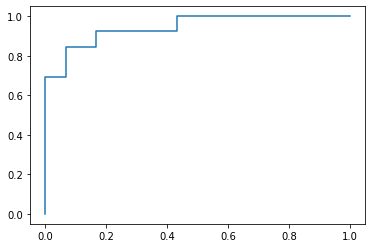

In [105]:
plt.plot(fpr, tpr)
plt.show()

In [106]:
roc_auc = auc(fpr,tpr)

In [107]:
print("Test AUC : ", roc_auc)

Test AUC :  0.9435897435897436


In [113]:
print(classification_report(y_test, clf.predict(X_test_final)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.85      0.85      0.85        13

    accuracy                           0.91        43
   macro avg       0.89      0.89      0.89        43
weighted avg       0.91      0.91      0.91        43



<h3>Save Model Artifacts</h3>

In [121]:
joblib.dump(ohe_X, './encoder.joblib')
joblib.dump(clf, './lgb_model.joblib')
joblib.dump(features, './features.joblib')
joblib.dump(cat_cols, './categorical_features.joblib')



['./categorical_features.joblib']